In [1]:
#GET GROUPLENS DATA
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip 

--2017-01-02 12:11:41--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 64:ff9b::8065:2292, 128.101.34.146
Connecting to files.grouplens.org (files.grouplens.org)|64:ff9b::8065:2292|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>]   5.64M  1.46MB/s    in 4.1s    

2017-01-02 12:11:46 (1.37 MB/s) - ‘moviedataset.zip’ saved [5917549/5917549]

Archive:  moviedataset.zip
checkdir:  cannot create extraction directory: /resources/data
           No such file or directory


In [4]:
!unzip -o moviedataset.zip -d Movie_data

Archive:  moviedataset.zip
   creating: Movie_data/ml-1m/
  inflating: Movie_data/ml-1m/movies.dat  
  inflating: Movie_data/ml-1m/ratings.dat  
  inflating: Movie_data/ml-1m/README  
  inflating: Movie_data/ml-1m/users.dat  


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#IMPORT DATA TO PANDAS
print 'Movies: '
movies_df = pd.read_csv('Movie_data/ml-1m/movies.dat', sep="::", header=None)
print movies_df.head()
print '\n\nRatings: '
ratings_df = pd.read_csv('Movie_data/ml-1m/ratings.dat', sep="::", header=None)
print ratings_df.head()

Movies: 
   0                                   1                             2
0  1                    Toy Story (1995)   Animation|Children's|Comedy
1  2                      Jumanji (1995)  Adventure|Children's|Fantasy
2  3             Grumpier Old Men (1995)                Comedy|Romance
3  4            Waiting to Exhale (1995)                  Comedy|Drama
4  5  Father of the Bride Part II (1995)                        Comedy


Ratings: 


/home/ac07/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/ac07/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


   0     1  2          3
0  1  1193  5  978300760
1  1   661  3  978302109
2  1   914  3  978301968
3  1  3408  4  978300275
4  1  2355  5  978824291


In [3]:
movies_df.columns = ['movie_id','title','genres']
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'time_stamp']

FORMAT THE DATA

In [4]:
print 'Check movie_id tally'
print len(movies_df)
print movies_df.tail()
print '\n\n'

#Since the movie_ids show that some films are missing, we create a pseudo-index to index into movies sequentially
movies_df['list_indx'] = movies_df.index
print 'Updated Movie_df'
print movies_df.head()

Check movie_id tally
3883
      movie_id                       title          genres
3878      3948     Meet the Parents (2000)          Comedy
3879      3949  Requiem for a Dream (2000)           Drama
3880      3950            Tigerland (2000)           Drama
3881      3951     Two Family House (2000)           Drama
3882      3952       Contender, The (2000)  Drama|Thriller



Updated Movie_df
   movie_id                               title                        genres  \
0         1                    Toy Story (1995)   Animation|Children's|Comedy   
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         3             Grumpier Old Men (1995)                Comedy|Romance   
3         4            Waiting to Exhale (1995)                  Comedy|Drama   
4         5  Father of the Bride Part II (1995)                        Comedy   

   list_indx  
0          0  
1          1  
2          2  
3          3  
4          4  


In [5]:
#merge the movies and the ratings dataframes
merged_df = movies_df.merge(ratings_df, on = 'movie_id')
print merged_df.head()

   movie_id             title                       genres  list_indx  \
0         1  Toy Story (1995)  Animation|Children's|Comedy          0   
1         1  Toy Story (1995)  Animation|Children's|Comedy          0   
2         1  Toy Story (1995)  Animation|Children's|Comedy          0   
3         1  Toy Story (1995)  Animation|Children's|Comedy          0   
4         1  Toy Story (1995)  Animation|Children's|Comedy          0   

   user_id  rating  time_stamp  
0        1       5   978824268  
1        6       4   978237008  
2        8       4   978233496  
3        9       5   978225952  
4       10       5   978226474  


In [6]:
#Tally
print len(merged_df.movie_id.unique()), len(merged_df), len(merged_df.user_id.unique())
print len(movies_df.movie_id.unique()), len(movies_df), len(ratings_df.user_id.unique()), len(ratings_df)

3706 1000209 6040
3883 3883 6040 1000209


In [7]:
#Drop Unnecessary Columns
merged_df = merged_df.drop('time_stamp', axis=1).drop('title',axis=1).drop('genres', axis=1)
print merged_df.head()

   movie_id  list_indx  user_id  rating
0         1          0        1       5
1         1          0        6       4
2         1          0        8       4
3         1          0        9       5
4         1          0       10       5


In [8]:
userGroup = merged_df.groupby('user_id')
print type(userGroup)

<class 'pandas.core.groupby.DataFrameGroupBy'>


In [38]:
#TRAINING_DATA

from __future__ import division
train_x = []
limit_training = 1000

#Iterate over each user and their merged_df dataframe values
for user, user_details in userGroup:
    if limit_training > 0:
        r_data = [0]*len(movies_df)
        #For each user, iterate over all the movies they rated and store the normalized ratings
        for indx, row in user_details.iterrows():
            r_data[row['list_indx']] = row['rating']/5.0
        train_x.append(r_data)
    limit_training -= 1


In [61]:
len(train_x)

1000

BUILDING THE RBM

In [65]:
#Define the layers - Visible Layer, Hidden Layer and Weights
visible_units = len(movies_df.movie_id.unique())
hidden_units = 50
vb = tf.placeholder("float", [visible_units])
hb = tf.placeholder("float", [hidden_units])
W = tf.placeholder("float", [visible_units, hidden_units])

In [66]:
#FORWARD PASS - Visible to Hidden and Sample from the Sigmoid Activated Hidden Layer
v0 = tf.placeholder("float", [None, visible_units])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)  #probabilities of the hidden units
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #sample_h_given_X

In [67]:
#BACKWARD PASS - Hidden to Visible and Sample from the Sigmoid Activated Visible Layer
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #sample_v_given_h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [68]:
#BackProp into Weights Requires Positive Gradient & Negative Gradient
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [69]:
err = tf.reduce_mean(tf.square(v0-v1))

In [70]:
cur_w  = np.zeros([visible_units, hidden_units], np.float32)
cur_vb = np.zeros([visible_units], np.float32)
cur_hb = np.zeros([hidden_units], np.float32)
prv_w  = np.zeros([visible_units, hidden_units], np.float32)
prv_vb = np.zeros([visible_units], np.float32)
prv_hb = np.zeros([hidden_units], np.float32)
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


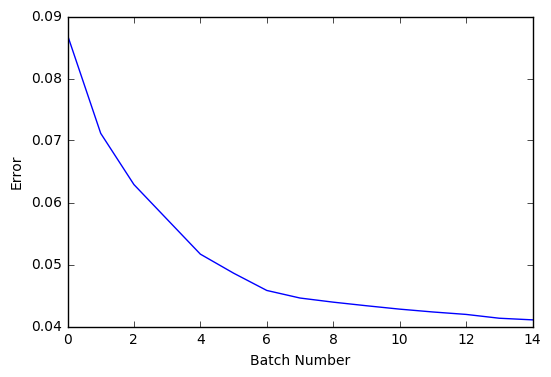

In [74]:
epochs = 15
batchsize = 100
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(train_x), batchsize), range(batchsize, len(train_x), batchsize)):
        batch = train_x[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err, feed_dict={v0:train_x, W: cur_w, vb:cur_vb, hb:cur_hb }))

plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()
            

In [77]:
i_user = [train_x[75]]
hh0 = tf.nn.sigmoid(tf.matmul(v0,W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: i_user, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb:prv_vb})

In [86]:
movies_df['Recommended_Score'] = rec[0]
movies_df.sort(['Recommended_Score'], ascending=False).head(20)

/home/ac07/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,movie_id,title,genres,list_indx,Recommended_Score
264,267,Major Payne (1994),Comedy,264,0.843137
1960,2029,Billy's Hollywood Screen Kiss (1997),Comedy|Romance,1960,0.529169
357,361,It Could Happen to You (1994),Drama|Romance,357,0.527963
3046,3115,Flawless (1999),Drama,3046,0.517572
3351,3420,...And Justice for All (1979),Drama|Thriller,3351,0.435559
1867,1936,Mrs. Miniver (1942),Drama|War,1867,0.421135
1878,1947,West Side Story (1961),Musical|Romance,1878,0.418912
3767,3837,Phantasm II (1988),Horror,3767,0.418739
1730,1789,"Sadness of Sex, The (1995)",Drama,1730,0.409929
1881,1950,In the Heat of the Night (1967),Drama|Mystery,1881,0.397177
